## 3. Reference Model

A statistical language model will be trained using the prepared data. It uses a distributed representation for words so that different words with similar meanings have a similar representation. It also learns the probability for the next word using the context of the last 100 words. The embedding layer will be used to learn the representation of words and Long-Short Term Memory (LSTM) recurrent neural network to learn to predict words based on their context.

In [1]:
# import libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy import array
from pickle import dump
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding

In [2]:
# set random seed for numpy and tensorflow
np.random.seed(1234)
tf.random.set_seed(1234)

### 3.1 Load Sequences

In [3]:
# load doc into memory
def load_doc(filename):
    # open file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load file 
in_filename = '../data/Text_Sequences_50_meta.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

In [4]:
# print first 50 lines
lines[:50]

['one morning when gregor samsa woke from troubled dreams he found himself transformed in his bed into a horrible vermin he lay on his armour like back and if he lifted his head a little he could see his brown belly slightly domed and divided by arches into stiff sections the',
 'morning when gregor samsa woke from troubled dreams he found himself transformed in his bed into a horrible vermin he lay on his armour like back and if he lifted his head a little he could see his brown belly slightly domed and divided by arches into stiff sections the bedding',
 'when gregor samsa woke from troubled dreams he found himself transformed in his bed into a horrible vermin he lay on his armour like back and if he lifted his head a little he could see his brown belly slightly domed and divided by arches into stiff sections the bedding was',
 'gregor samsa woke from troubled dreams he found himself transformed in his bed into a horrible vermin he lay on his armour like back and if he lifted his hea

### 3.2 Encode Sequences

#### Encode Sequences of Words into Integers

In [5]:
# instantiate Tokenizer
tokenizer = Tokenizer()
# updates internal vocabulary with each unique word in each line in lines
tokenizer.fit_on_texts(lines)  
# transform each text in lines to a sequence of integers
sequences = tokenizer.texts_to_sequences(lines)  

In [6]:
# view the sequence of integers in the first list in sequences
print(sequences[0])

[49, 155, 54, 16, 109, 1257, 28, 2533, 2527, 4, 242, 41, 2531, 9, 5, 122, 46, 12, 886, 2530, 4, 165, 25, 5, 2529, 85, 42, 3, 34, 4, 485, 5, 84, 12, 66, 4, 29, 83, 5, 688, 885, 370, 2526, 3, 2524, 63, 2523, 46, 884, 2522, 1]


In [7]:
# display length of each sequence
len(sequences[0])

51

In [8]:
# display total number of sequences
len(sequences)

21296

In [9]:
# vocabulary size
vocab_size = len(tokenizer.word_index) + 1

print('Vocabulary size is '+ str(vocab_size) + '.')

Vocabulary size is 2534.


The vocabulary size is necessary for defining the embedding layer. The vocabulary size is determined by calculating the size of the mapping dictionary using word_index. As the indexing of arrays is zero-offset, the array must be 2533 + 1 in length. 

### 3.3 Sequence Inputs & Output

#### Assign X and y variables

In [10]:
# separate into input and output

# convert list of lines in sequences to an array
sequences = array(sequences)
# X will contain the first 50 words (elements) in each line (dimension)
X = sequences[:,:-1]
# y will contain the last word (element) in each line (dimension) which will be used to train the predicted word
y = sequences[:,-1]

In [11]:
# seq_length will be the number of words (elements) in each line
seq_length = X.shape[1]
seq_length

50

In [12]:
# check shape of X
X.shape

(21296, 50)

In [13]:
# preview X variable
print(X)

[[  49  155   54 ...   46  884 2522]
 [ 155   54   16 ...  884 2522    1]
 [  54   16  109 ... 2522    1 1258]
 ...
 [ 192 1250    3 ...   44    3  887]
 [1250    3  185 ...    3  887   31]
 [   3  185   79 ...  887   31   18]]


X has 21296 dimensions (rows of sequences) and 50 elements (words).

In [14]:
# check shape of y
y.shape

(21296,)

In [15]:
# view output of y
print(y)
print(type(y))

[   1 1258    7 ...   31   18  888]
<class 'numpy.ndarray'>


In [16]:
# converts a class vector (integers) to binary class matrix where number of columns = vocab_size.
y = to_categorical(y, num_classes=vocab_size)

In [17]:
# check shape of y after converting to binary class matrix
y.shape

(21296, 2534)

From the shape of y, the array consists of 21296 rows (sequences) and 2534 features (vocabulary size).

In [18]:
# preview Y variable
print(y)
print(type(y))

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
<class 'numpy.ndarray'>


### 3.4 Modelling

#### Define & Fit Model

- In the embedding layer, "input_dim" refers to the vocabulary size (maximum integer index + 1) while "output_dim" is the dimension of the dense embedding. "input_length" is the length of input sequences, when it is constant.
- In the LSTM layer, the unit refers to dimensionality of the output space. It refers to the dimension of hidden state vector a that is the state output from RNN/LSTM cell.

In [19]:
# define the model function
# input_dim refers to vocab_size and seq_length refers to output_dim and input_length in the embedding layer
# vocab_size = 2534 and seq_length = 50

def define_model():
    model = Sequential()
    # input_dim=2534, output_dim=50, input_length=50
    model.add(Embedding(2534, 50, input_length=50))
    # Set return_sequences=True when stacking LSTM layers so that the second LSTM layer has a three-dimensional sequence input. 
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(100))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(2534, activation='softmax'))
    # compile network
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [20]:
# define model
model = define_model()              

In [21]:
# fit model and assign as history
history = model.fit(X, y, batch_size=128, epochs=100)

Epoch 1/100
167/167 [==============================] - 24s 126ms/step - loss: 6.3453 - accuracy: 0.0504
Epoch 2/100
167/167 [==============================] - 19s 115ms/step - loss: 5.9873 - accuracy: 0.0537
Epoch 3/100
167/167 [==============================] - 19s 114ms/step - loss: 5.8740 - accuracy: 0.0547
Epoch 4/100
167/167 [==============================] - 19s 114ms/step - loss: 5.7394 - accuracy: 0.0595
Epoch 5/100
167/167 [==============================] - 19s 114ms/step - loss: 5.6136 - accuracy: 0.0692
Epoch 6/100
167/167 [==============================] - 19s 113ms/step - loss: 5.5229 - accuracy: 0.0773
Epoch 7/100
167/167 [==============================] - 19s 114ms/step - loss: 5.4374 - accuracy: 0.0799
Epoch 8/100
167/167 [==============================] - 19s 113ms/step - loss: 5.3560 - accuracy: 0.0891
Epoch 9/100
167/167 [==============================] - 19s 114ms/step - loss: 5.2731 - accuracy: 0.0934
Epoch 10/100
167/167 [==============================] - 19s 116m

167/167 [==============================] - 19s 113ms/step - loss: 2.8913 - accuracy: 0.3226
Epoch 80/100
167/167 [==============================] - 19s 113ms/step - loss: 2.8638 - accuracy: 0.3275
Epoch 81/100
167/167 [==============================] - 19s 114ms/step - loss: 2.8418 - accuracy: 0.3307
Epoch 82/100
167/167 [==============================] - 19s 114ms/step - loss: 2.8176 - accuracy: 0.3369
Epoch 83/100
167/167 [==============================] - 19s 113ms/step - loss: 2.7933 - accuracy: 0.3408
Epoch 84/100
167/167 [==============================] - 19s 114ms/step - loss: 2.7715 - accuracy: 0.3434
Epoch 85/100
167/167 [==============================] - 19s 113ms/step - loss: 2.7474 - accuracy: 0.3446
Epoch 86/100
167/167 [==============================] - 19s 114ms/step - loss: 2.7221 - accuracy: 0.3507
Epoch 87/100
167/167 [==============================] - 19s 113ms/step - loss: 2.6957 - accuracy: 0.3578
Epoch 88/100
167/167 [==============================] - 19s 113ms/st

#### Plot Accuracy & Loss Curve

In [22]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


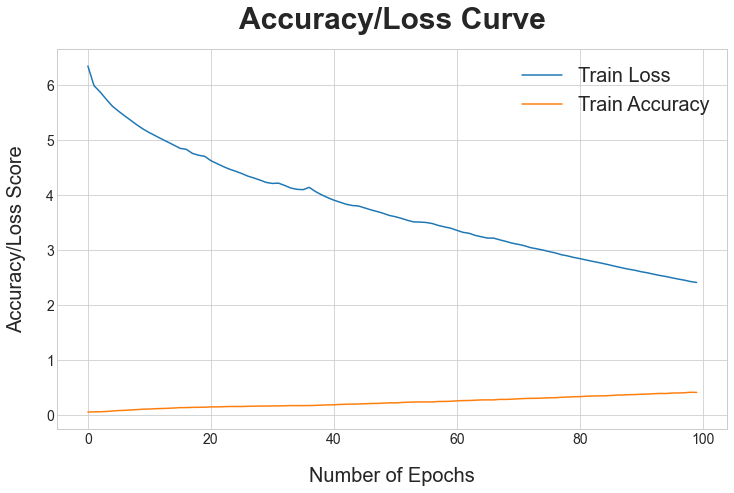

In [23]:
# plot train accuracy and loss curves

# figure size and plot style
plt.figure(figsize=(12,7)) 
plt.style.use('seaborn-whitegrid') 

# plot loss and accuracy curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.legend(fontsize=20);

# plot title
plt.title('Accuracy/Loss Curve', fontsize=30, pad=20, weight='bold')
# x-axis label
plt.xlabel('Number of Epochs', fontsize=20, labelpad=20)
# y-axis label
plt.ylabel('Accuracy/Loss Score', fontsize=20, labelpad=20)
# x-ticks
plt.xticks(fontsize=14)
# y-ticks
plt.yticks(fontsize=14)

plt.savefig('../data/Acc_Loss_Curve_Ref_Model.png')

From the accuracy/loss curve above, we observe that there is a gradual decrease in loss score as the number of epochs increases. On the other hand, the accuracy score of the model increases gradually as the number of epochs increases. However, the accuracy score of the reference model would not be a good determinant of the language model performance in generating new text. According to the reference text, an accuracy score greater than 0.50 would likely produce decent results. We will examine the BLEU score after applying the model to generate new text and evluate the model performance.  

#### Model Summary

In [24]:
# print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            126700    
_________________________________________________________________
lstm (LSTM)                  (None, 50, 100)           60400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 2534)              255934    
Total params: 533,534
Trainable params: 533,534
Non-trainable params: 0
_________________________________________________________________


#### Save Model

In [26]:
# save model to file
model.save('model_ref.h5')
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))